In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense


from tcn import TCN

# Inverting representations

This section introduces the computation of an approximate
inverse of a time series representation. This is formulated
as the problem of finding a time series whose representation
best matches the one given.

## I/ Representation to be inverted

### 1/ The original time-serie

In [22]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',', usecols=['date', 'close', "Name"])
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.head()

,date,close,Name
1259,2013-02-08,67.8542,AAPL
1260,2013-02-11,68.5614,AAPL
1261,2013-02-12,66.8428,AAPL
1262,2013-02-13,66.7156,AAPL
1263,2013-02-14,66.6556,AAPL


In [5]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

In [15]:
close_aapl = df_AAPL['close'].values
ts_size = close_aapl.shape[0]

### 2/ The representation (TCN)

In [7]:
import tensorflow as tf

In [16]:
i = Input(shape=(ts_size, 1))
m = TCN()(i)
model = Model(inputs=[i], outputs=[m])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1259, 1)]         0         
_________________________________________________________________
tcn_4 (TCN)                  (None, 64)                136256    
Total params: 136,256
Trainable params: 136,256
Non-trainable params: 0
_________________________________________________________________


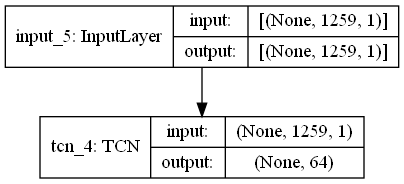

In [17]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 3/ The representation of the time serie

In [37]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model we may want to generate a variety of data windows. For examples:

1. For example, to make a single prediction 24 days into the future, given 24 days of history, we might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [29]:
column_indices = {name: i for i, name in enumerate(df_AAPL.columns)}

n = len(df_AAPL)
train_df = df_AAPL[0:int(n*0.7)]
val_df = df_AAPL[int(n*0.7):int(n*0.9)]
test_df = df_AAPL[int(n*0.9):]

num_features = df.shape[1]

### 3/ Loss function

In [ ]:
def loss(preds, target):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(target, preds).numpy()

### 4/ Regulariser

In [ ]:
def regulariser(x, alpha):
    return np.linalg.norm(x, alpha)

## II/ Optimisation